In [1]:
import bq  
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib
from matplotlib import colors,colorbar
import matplotlib
%matplotlib inline
import csv 
import math
from math import radians, cos, sin, asin, sqrt
from scipy import stats


client = bq.Client.Get()


In [2]:
def Query(q):
    t0 = time.time()
    answer = client.ReadTableRows(client.Query(q)['configuration']['query']['destinationTable'])
    print 'Query time: ' + str(time.time() - t0) + ' seconds.'
    return answer

In [3]:
q = '''
SELECT
  integer(FLOOR(a_first_lat*10)) lat_bin,
  integer(FLOOR(a_first_lon*10)) lon_bin,
  integer(FLOOR(a_avg_lat*10)) lat_bin_avg,
  integer(FLOOR(a_avg_lon*10)) lon_bin_avg,
  a_satellite_positions sat_positions,
  a_positions positions
FROM
  [scratch_david_gapanalysis.ave_locations_2015_with_density_v2]
WHERE
  a_date = "2015-01-01"
  AND a_max_lat - a_min_lat <5
  AND (a_max_lon - a_min_lon < 10
    OR a_first_lon > 170
    OR a_first_lon < -170)
  AND a_mmsi IN (select mmsi from
[scratch_david_gapanalysis.good_mmsi_2015]
  )
'''

positions = Query(q)

Waiting on bqjob_r66ea7413ed4f8a6a_000001530a9606b1_1 ... (7s) Current status: DONE   
Query time: 32.6689999104 seconds.


In [4]:
cellsize = 2
num_lons = 360/cellsize
num_lats = 180/cellsize

In [5]:
# first calculate a raster of vessel locations from the query

vessels = np.zeros(shape=(num_lats,num_lons)) 

for row in positions:
    lat = int(row[0])
    lon = int(row[1])
    if lat<900 and lat>-900 and lon>-1800 and lon<1800:
        lat_index = (lat+900)/(cellsize*10)
        lon_index = (lon+1800)/(cellsize*10)
        vessels[lat_index][lon_index] += 1 # one vessel 


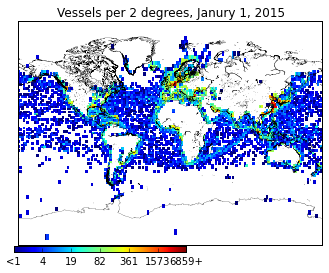

In [6]:
# map this density

firstlat = 90
lastlat = -90
firstlon = -180
lastlon = 180
scale = cellsize

numlats = int((firstlat-lastlat)/scale+.5)
numlons = int((lastlon-firstlon)/scale+.5)
    
lat_boxes = np.linspace(lastlat,firstlat,num=numlats,endpoint=False)
lon_boxes = np.linspace(firstlon,lastlon,num=numlons,endpoint=False)

fig = plt.figure()

m = Basemap(llcrnrlat=lastlat, urcrnrlat=firstlat,
          llcrnrlon=firstlon, urcrnrlon=lastlon, lat_ts=0, projection='mill',resolution="h")

m.drawmapboundary()
m.drawcoastlines(linewidth=.2)
#m.fillcontinents('#555555')#, lake_color, ax, zorder, alpha)


x = np.linspace(-180, 180, 360/cellsize )
y = np.linspace(lastlat, firstlat, (firstlat-lastlat)/cellsize)
x, y = np.meshgrid(x, y)
converted_x, converted_y = m(x, y)

from matplotlib import colors,colorbar
norm = colors.LogNorm(vmin=1, vmax=1000)
m3 = int(vessels.max()**.333) # set the max to the max of the scale

m.pcolormesh(converted_x, converted_y, vessels, norm=norm, vmin=1, vmax=m3**3)

t = "Vessels per 2 degrees, Janury 1, 2015"
plt.title(t)
ax = fig.add_axes([0.15, 0.1, 0.4, 0.02]) 
norm = colors.LogNorm(vmin=1, vmax=1000)
lvls = np.logspace(0,3,7)

cb = colorbar.ColorbarBase(ax,norm = norm, orientation='horizontal', ticks=lvls)
cb.ax.set_xticklabels(["<1" ,int(m3**.5), m3, int(m3**1.5), m3*m3,int(m3**2.5), str(int(m3**3))+"+"], fontsize=10)


#plt.savefig(".png",bbox_inches='tight',dpi=450,transparent=True,pad_inches=0)

plt.rcParams["figure.figsize"] = [12,8]
plt.show()

In [7]:
# create the density that is seen by satellites

# load the file that helps with the satellite averaging
grid_for_average = np.load('grid_for_average_2degree.npy')

averages = np.zeros(shape=(num_lats,num_lons)) # 2 by 2 grid

for i in range(num_lats):
    for j in range(num_lons):
        count = len(grid_for_average[i][j])
        total = 0
        for item in grid_for_average[i][j]:
            total += vessels[item[0]][item[1]]*item[2]
        averages[i][j]=total/4. 
        # divide by 4 because the satellite sees only 1/4 of the area that we're 
        #averaging over
            

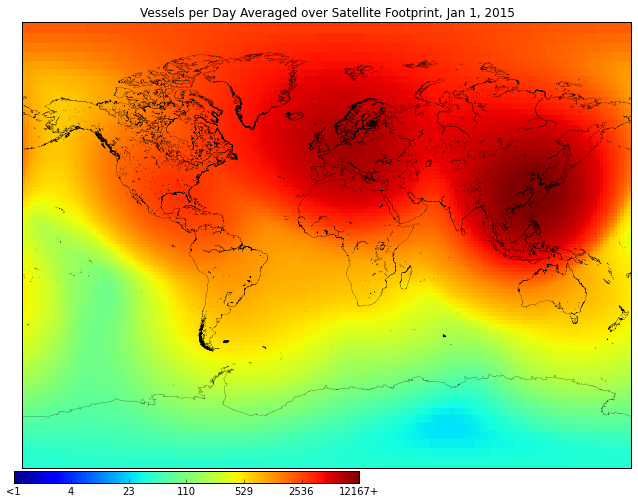

In [8]:
# map the vessel density seen by satellite

firstlat = 90
lastlat = -90
firstlon = -180
lastlon = 180
scale = cellsize

numlats = int((firstlat-lastlat)/scale+.5)
numlons = int((lastlon-firstlon)/scale+.5)
    
lat_boxes = np.linspace(lastlat,firstlat,num=numlats,endpoint=False)
lon_boxes = np.linspace(firstlon,lastlon,num=numlons,endpoint=False)

fig = plt.figure()
plt.clf()

m = Basemap(llcrnrlat=lastlat, urcrnrlat=firstlat,
          llcrnrlon=firstlon, urcrnrlon=lastlon, lat_ts=0, projection='mill',resolution="h")

m.drawmapboundary()
m.drawcoastlines(linewidth=.2)
#m.fillcontinents('#555555')# , lake_color, ax, zorder, alpha)

x = np.linspace(-180, 180, 360/cellsize )
y = np.linspace(lastlat, firstlat, (firstlat-lastlat)/cellsize)
x, y = np.meshgrid(x, y)
converted_x, converted_y = m(x, y)

from matplotlib import colors,colorbar

norm = colors.LogNorm(vmin=1, vmax=1000)

m3 = int(averages.max()**.3333)

m.pcolormesh(converted_x, converted_y, averages, norm=norm, vmin=1, vmax=m3**3)

t = "Vessels per Day Averaged over Satellite Footprint, Jan 1, 2015"
plt.title(t)

ax = fig.add_axes([0.15, 0.1, 0.4, 0.02]) 
norm = colors.Normalize(vmin=0, vmax=1000)
norm = colors.LogNorm(vmin=1, vmax=1000)
lvls = np.logspace(0,3,7)

cb = colorbar.ColorbarBase(ax,norm = norm, orientation='horizontal', ticks=lvls)

cb.ax.set_xticklabels(["<1" ,int(m3**.5), m3, int(m3**1.5), m3*m3,int(m3**2.5), str(int(m3**3))+"+"], fontsize=10)


#plt.savefig("satellite_footprint2by2.png",bbox_inches='tight',dpi=450,transparent=True,pad_inches=0)

plt.rcParams["figure.figsize"] = [12,8]

plt.show()

In [9]:
# now make a chart of pings versus position

den = []
pos = []
count = 0

for row in positions:
    lat = int(row[2])
    lon_ave = int(row[3])
    lon_f = int(row[1])
    if abs(lon_f - lon_ave > 50): # use average, except near the dateline
        lon = lon_f
    else:
        lon = lon_ave
    sat_pos = row[4]
    all_pos = row[5]
    count += 1
    # must only be satellite positions
    if sat_pos == all_pos and lat<900 and lat>-900 and lon>-1800 and lon<1800:
        lat_index = (lat+900)/(cellsize*10)
        lon_index = (lon+1800)/(cellsize*10)
        den.append(averages[lat_index][lon_index])
        pos.append(int(sat_pos))

-0.780339163118 0.00962217464253 0.0


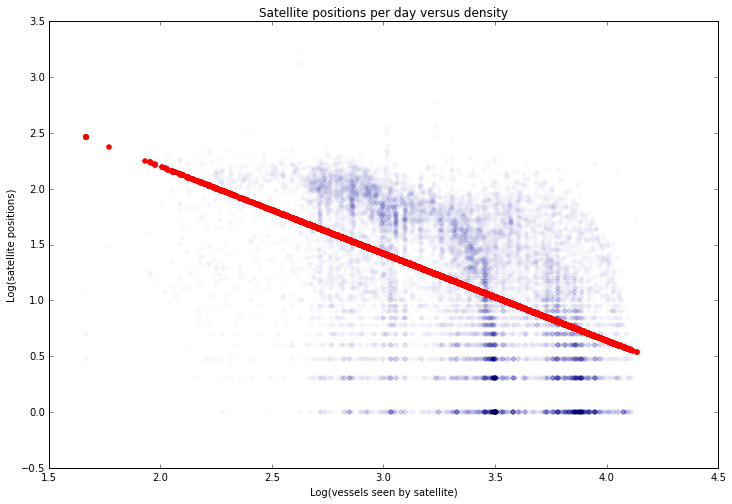

In [10]:
x = den
y = pos

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
# ax.set_yscale('log')
# ax.set_xscale('log')

plt.scatter(np.log10(x), np.log10(y), alpha=.01)#, color = color)
# plt.scatter(x1, y1, alpha=1)#, color = color)

logA = np.log10(x)
logB = np.log10(y)
coefficients = np.polyfit(logA, logB, 1)
polynomial = np.poly1d(coefficients)
ys = polynomial(np.log10(x))
slope, intercept, r_value, p_value, std_err = stats.linregress(logA, logB)

plt.scatter(np.log10(x), ys, color = 'red')


# print slope
# print coefficients
# print r_value
# print p_value
print slope,std_err,p_value

plt.title("Satellite positions per day versus density")
plt.xlabel('Log(vessels seen by satellite)')
plt.ylabel('Log(satellite positions)')

plt.show()

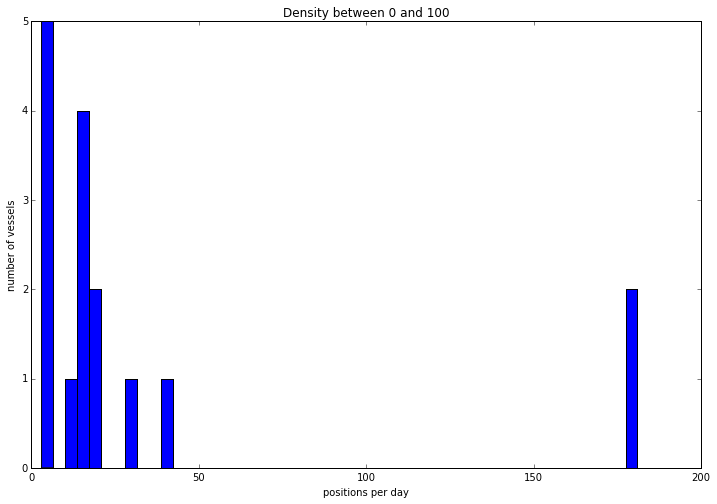

Density between 0 and 100 :  31


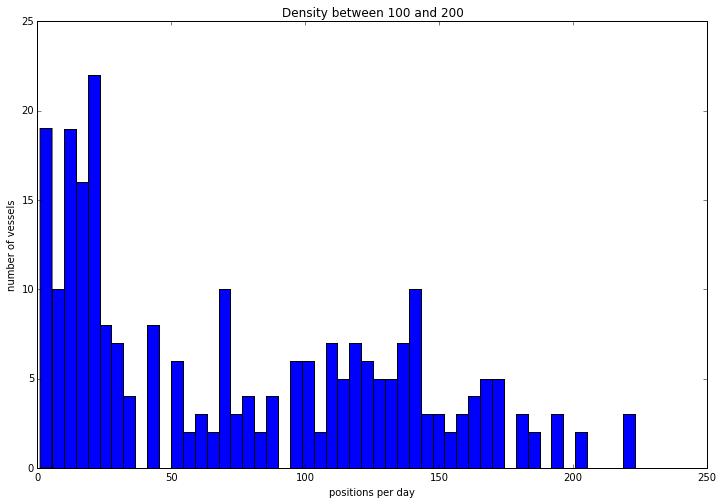

Density between 100 and 200 :  11


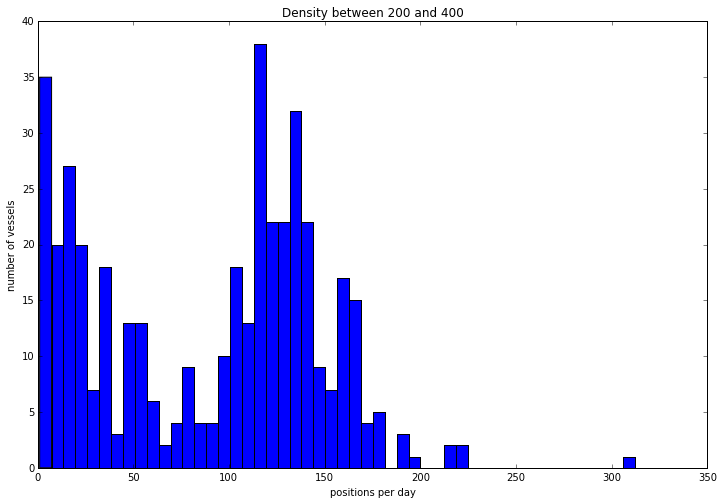

Density between 200 and 400 :  9


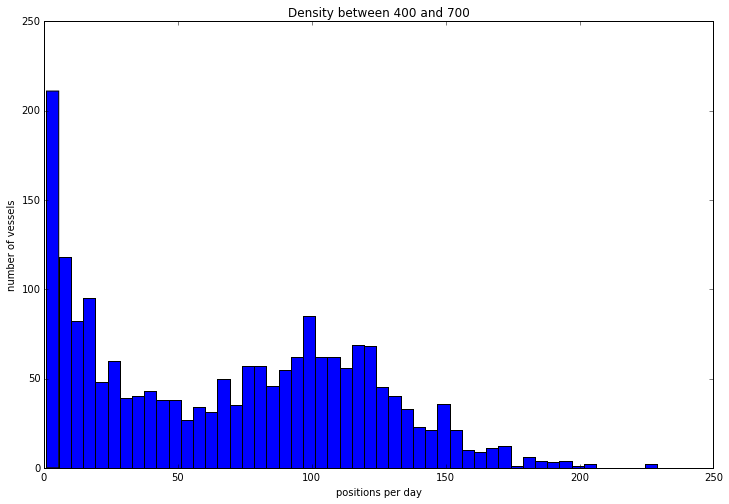

Density between 400 and 700 :  15


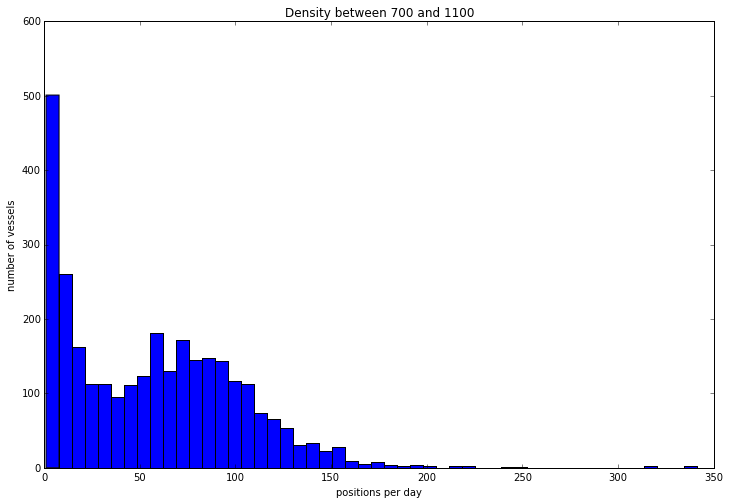

Density between 700 and 1100 :  19


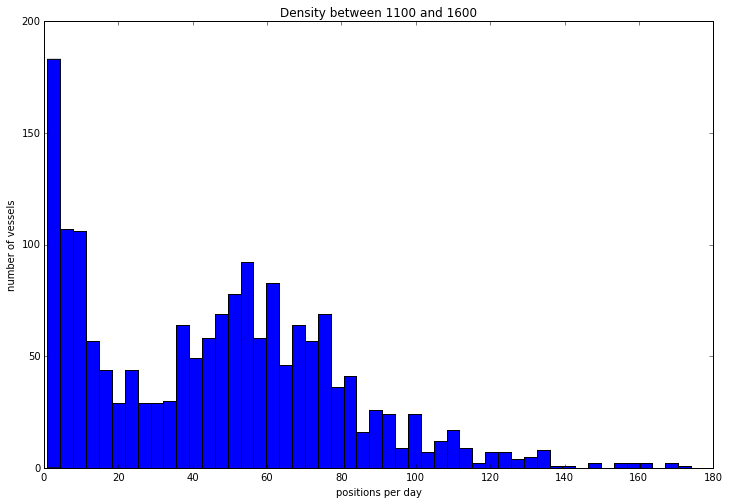

Density between 1100 and 1600 :  20


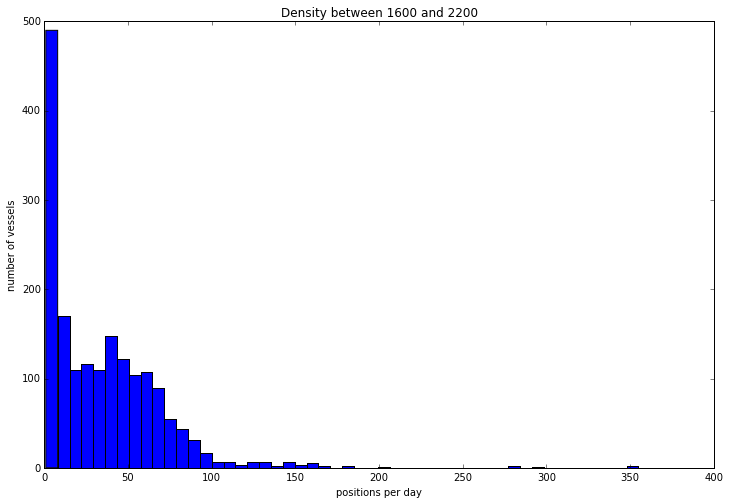

Density between 1600 and 2200 :  29


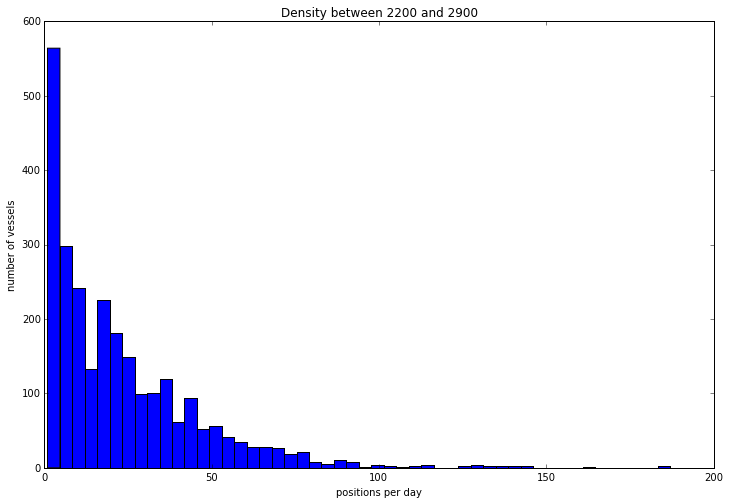

Density between 2200 and 2900 :  34


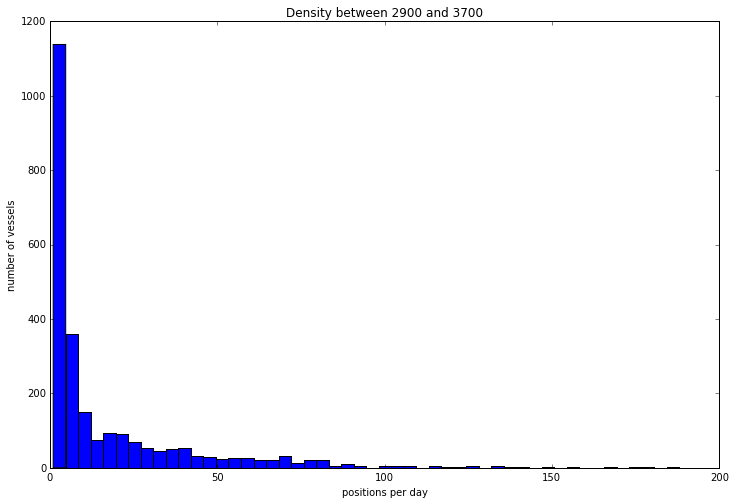

Density between 2900 and 3700 :  61


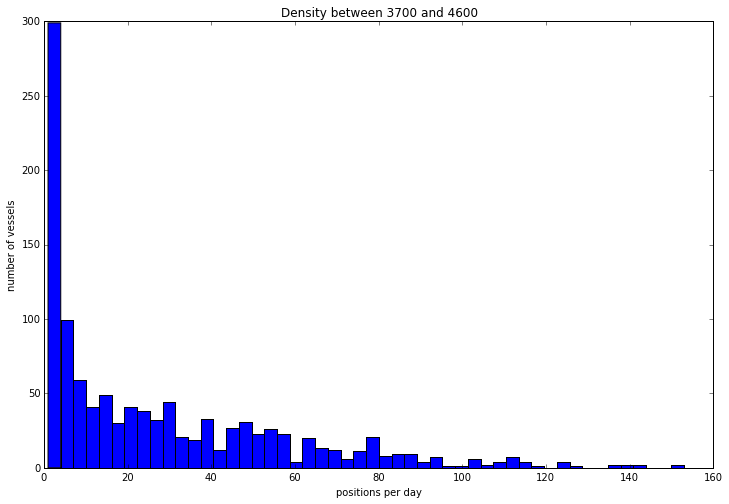

Density between 3700 and 4600 :  39


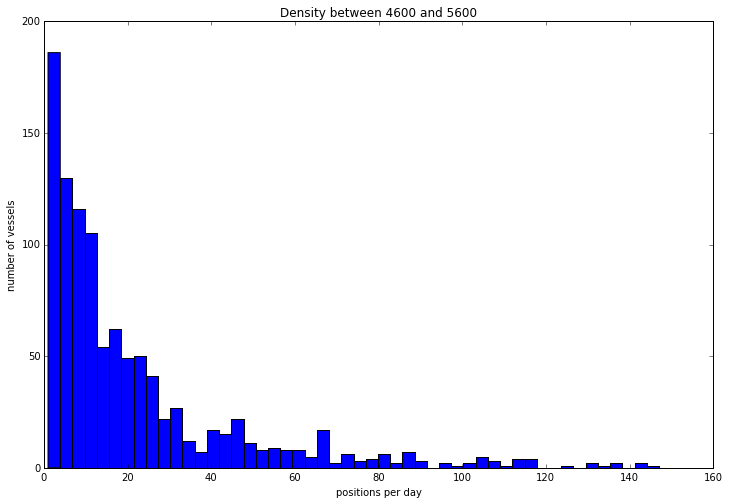

Density between 4600 and 5600 :  41


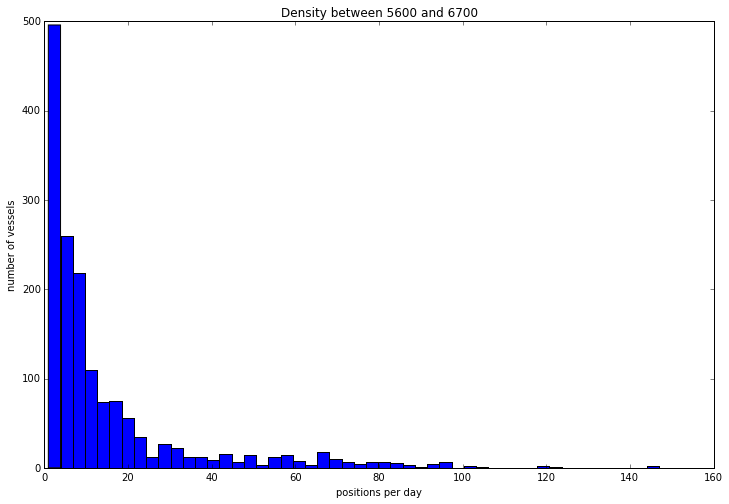

Density between 5600 and 6700 :  61


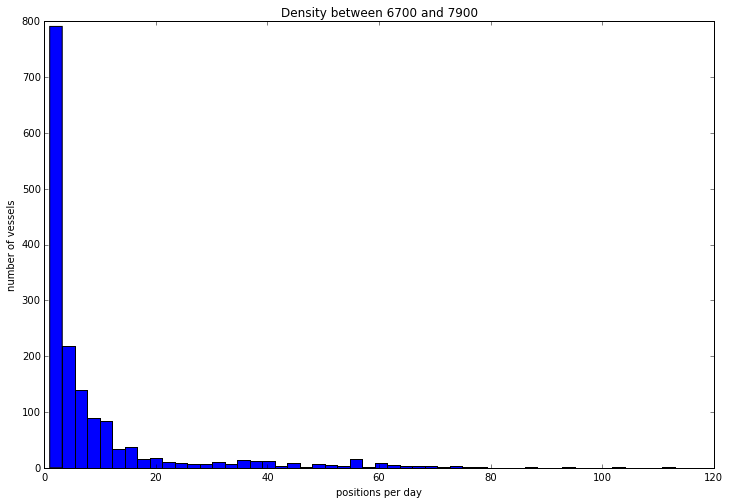

Density between 6700 and 7900 :  77


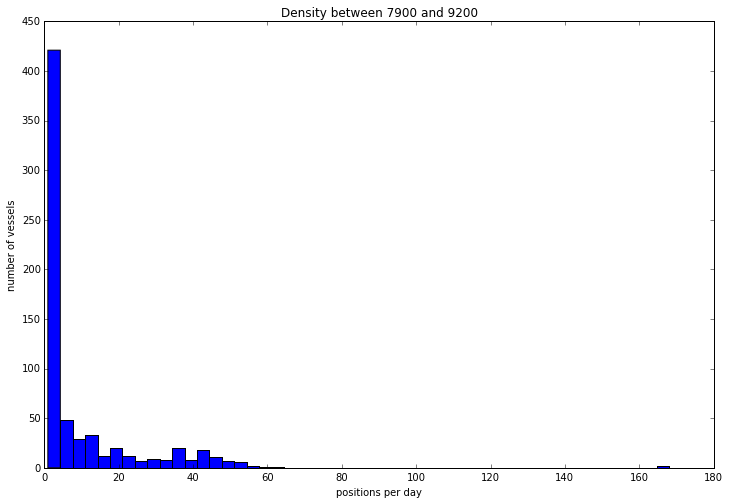

Density between 7900 and 9200 :  72


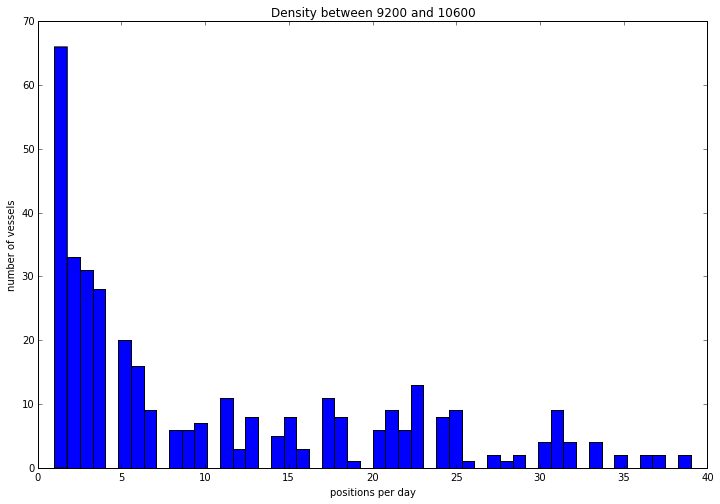

Density between 9200 and 10600 :  58


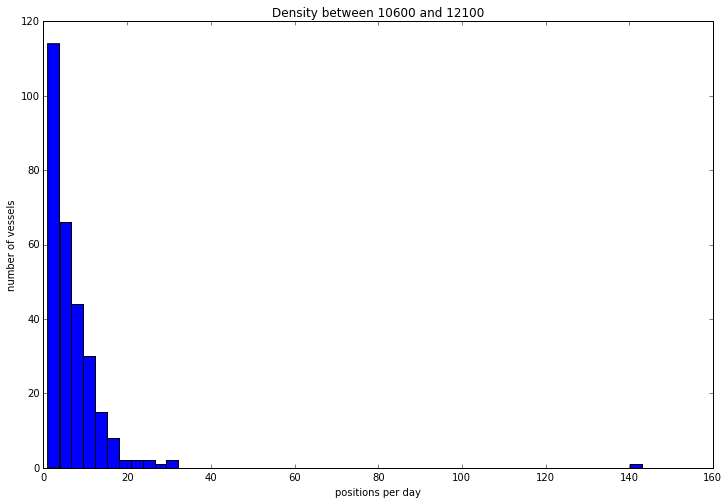

Density between 10600 and 12100 :  78


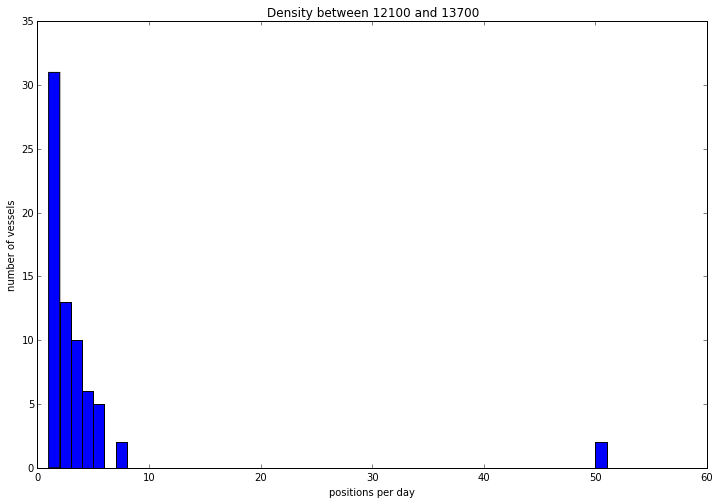

Density between 12100 and 13700 :  97


ValueError: x must have at least one data point

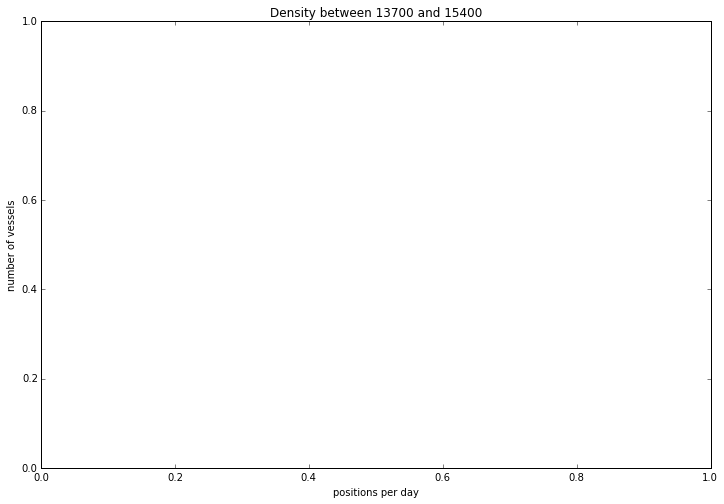

In [12]:
minimum = 0
maximum = 100

for i in range(18):

    x = []

    plt.clf()
    if i > 0:
        minimum = maximum
    maximum += 100*i
    
    less_than_5 = 0
    count = 0
    for p, d in zip (pos, den):
        if d>minimum and d<maximum and p<400:
            x.append(p)
            if p<10:
                less_than_5 += 1
            count+=1
    plt.title("Density between "+str(minimum)+" and "+str(maximum))     
    plt.xlabel("positions per day")
    plt.ylabel("number of vessels")
    plt.hist(x, bins=50)
    plt.show()
    print "Density between "+str(minimum)+" and "+str(maximum) + " : ", int(100*less_than_5/count)

In [13]:
# okay, let's look at only fishing vessels

q = '''
SELECT
  integer(FLOOR(a_first_lat*10)) lat_bin,
  integer(FLOOR(a_first_lon*10)) lon_bin,
  integer(FLOOR(a_avg_lat*10)) lat_bin_avg,
  integer(FLOOR(a_avg_lon*10)) lon_bin_avg,
  a_satellite_positions sat_positions,
  a_positions positions
FROM
  [scratch_david_gapanalysis.ave_locations_2015_with_density_v2]
WHERE
  a_date = "2015-01-01"
  AND a_max_lat - a_min_lat <5
  AND (a_max_lon - a_min_lon < 10
    OR a_first_lon > 170
    OR a_first_lon < -170)
  AND a_mmsi IN (select mmsi from
[scratch_david_mmsi_lists.Combinedfishing_2014]
  )
'''

positions_fishing_vessels = Query(q)


Waiting on bqjob_r6a16a99088a29707_000001530ad38aee_2 ... (7s) Current status: DONE   
Query time: 16.1007111073 seconds.


In [14]:
# now make a chart of pings versus position

den = []
pos = []
count = 0

for row in positions_fishing_vessels:
    lat = int(row[2])
    lon_ave = int(row[3])
    lon_f = int(row[1])
    if abs(lon_f - lon_ave > 50): # use average, except near the dateline
        lon = lon_f
    else:
        lon = lon_ave
    sat_pos = row[4]
    all_pos = row[5]
    count += 1
    # must only be satellite positions
    if sat_pos == all_pos and lat<900 and lat>-900 and lon>-1800 and lon<1800:
        lat_index = (lat+900)/(cellsize*10)
        lon_index = (lon+1800)/(cellsize*10)
        den.append(averages[lat_index][lon_index])
        pos.append(int(sat_pos))

-0.585306674036 0.0293862270318 3.75524846468e-79


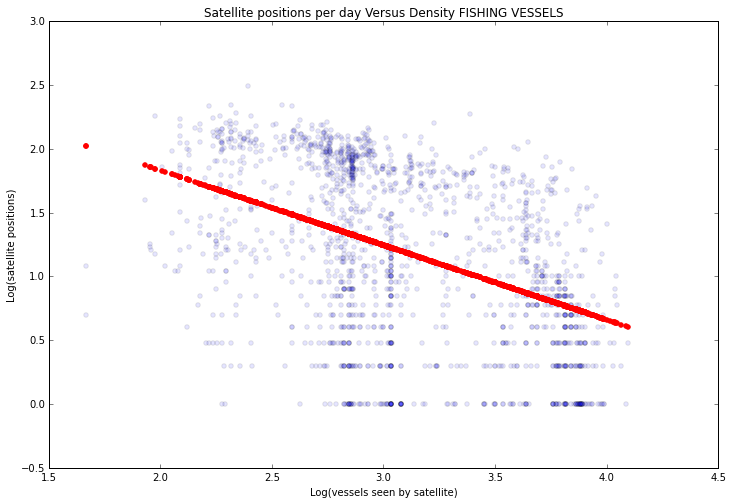

In [15]:
x = den
y = pos

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
# ax.set_yscale('log')
# ax.set_xscale('log')

plt.scatter(np.log10(x), np.log10(y), alpha=.1)#, color = color)
# plt.scatter(x1, y1, alpha=1)#, color = color)

logA = np.log10(x)
logB = np.log10(y)
coefficients = np.polyfit(logA, logB, 1)
polynomial = np.poly1d(coefficients)
ys = polynomial(np.log10(x))
slope, intercept, r_value, p_value, std_err = stats.linregress(logA, logB)

plt.scatter(np.log10(x), ys, color = 'red')


# print slope
# print coefficients
# print r_value
# print p_value
print slope,std_err,p_value

plt.title("Satellite positions per day Versus Density FISHING VESSELS")
plt.xlabel('Log(vessels seen by satellite)')
plt.ylabel('Log(satellite positions)')

plt.show()

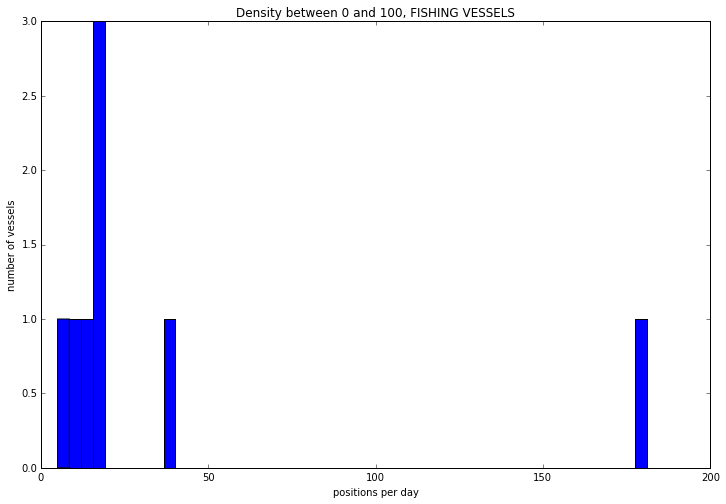

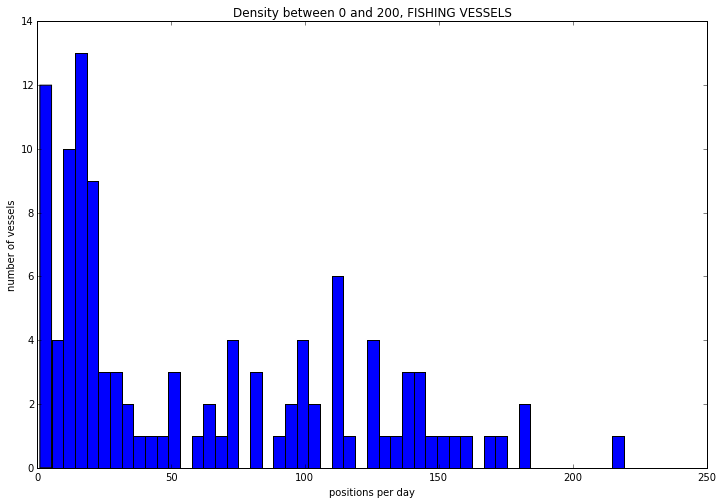

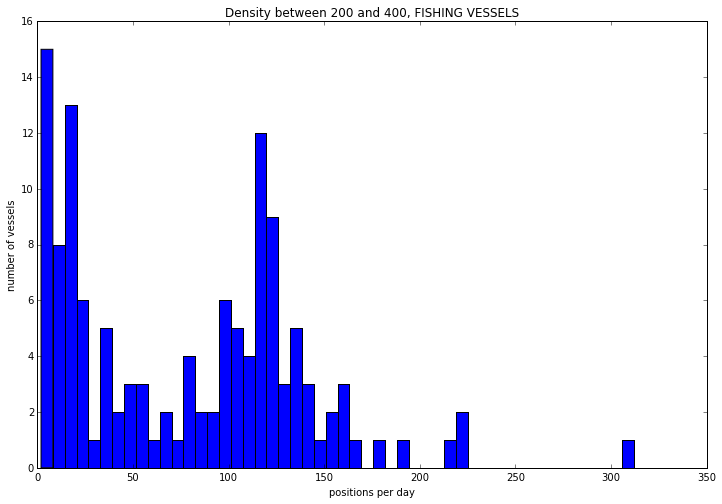

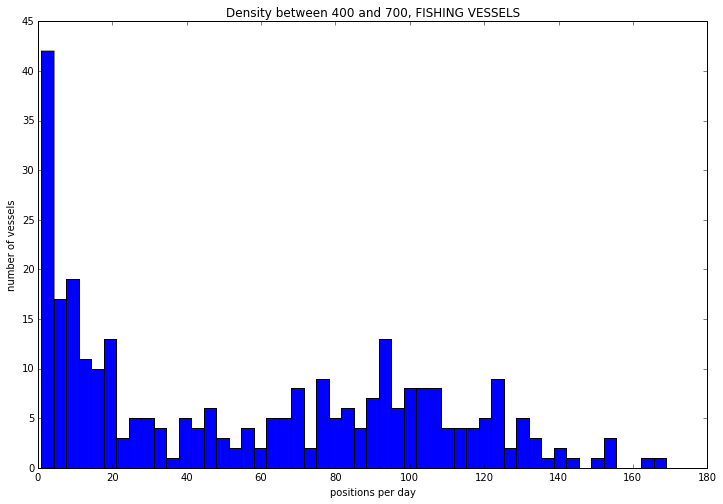

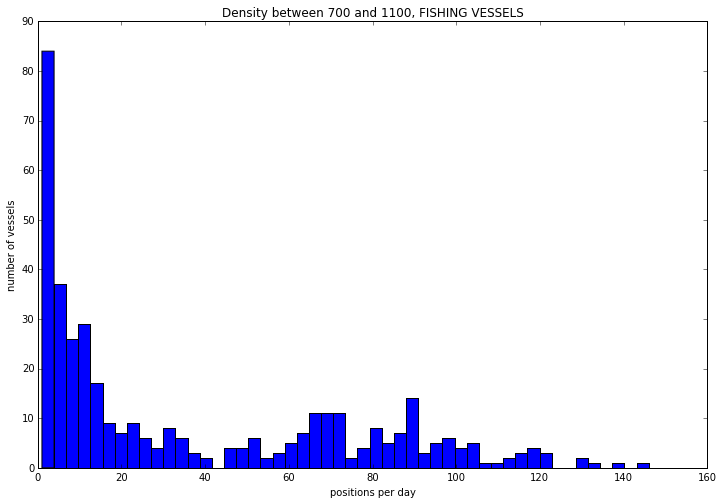

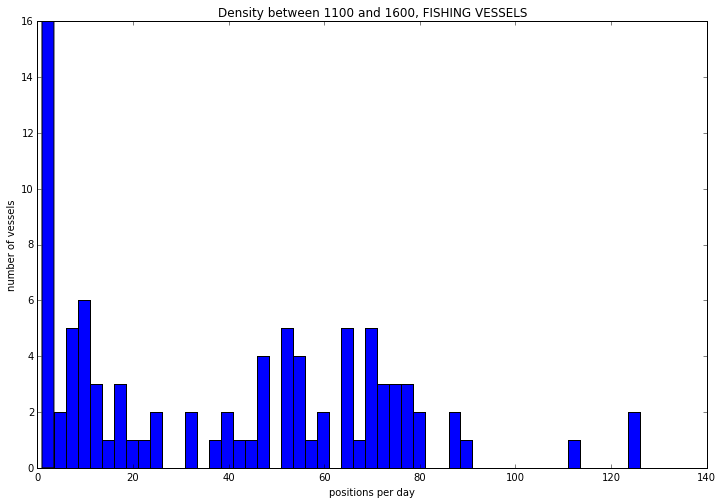

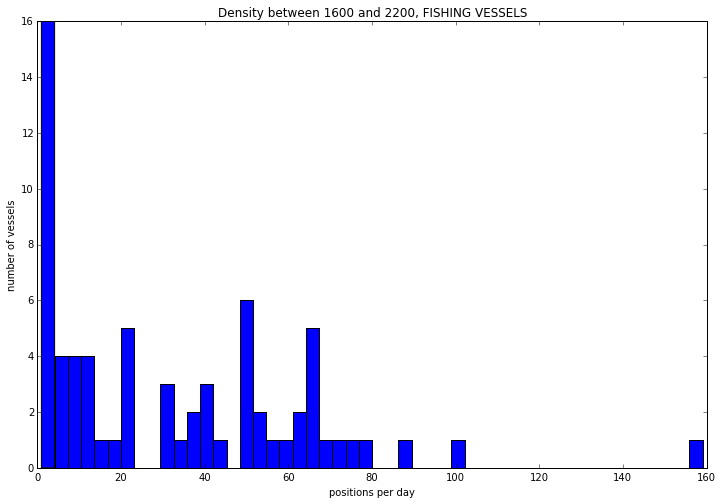

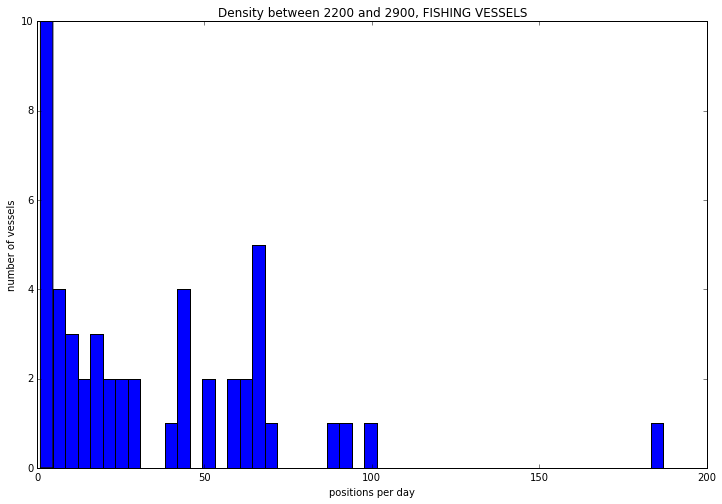

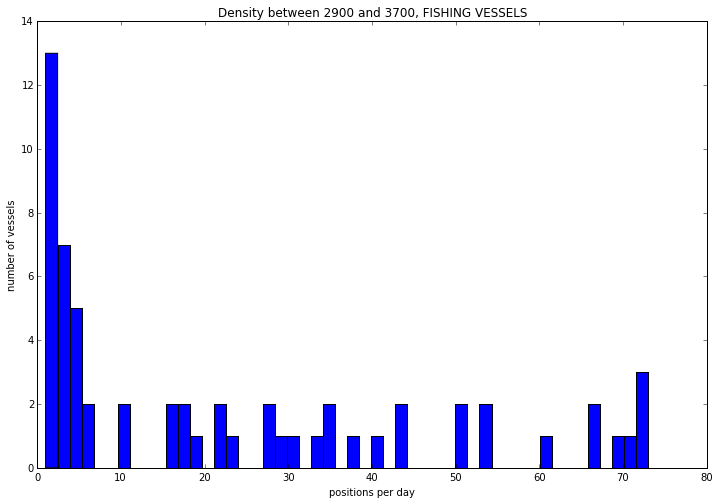

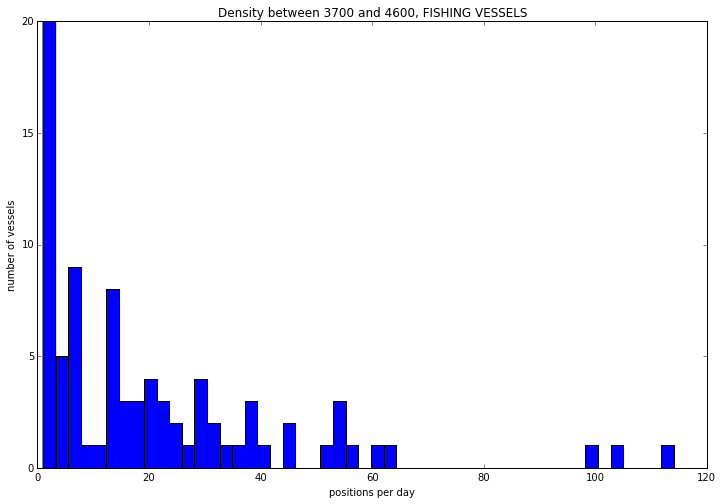

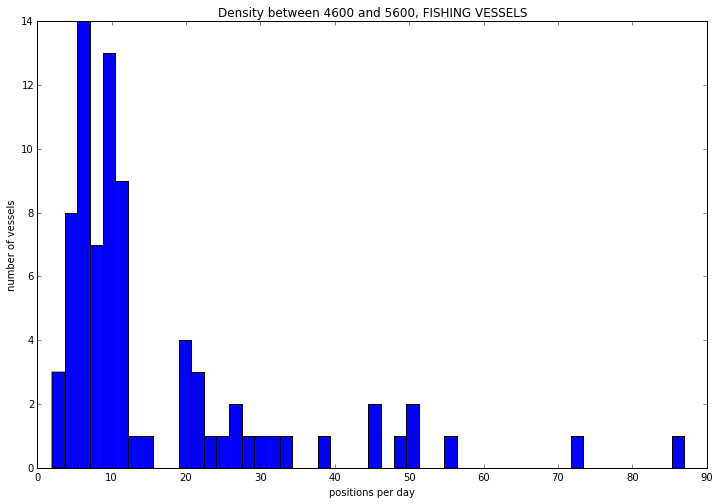

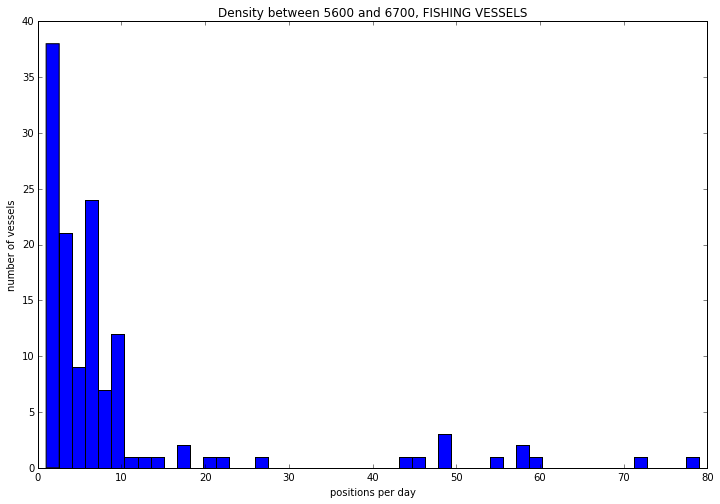

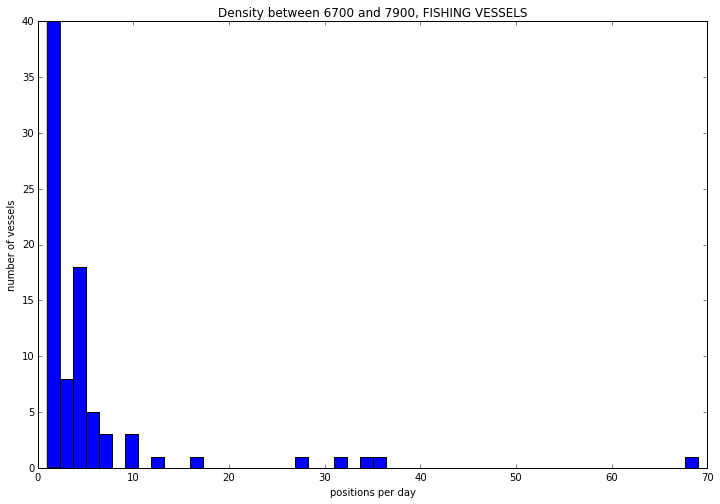

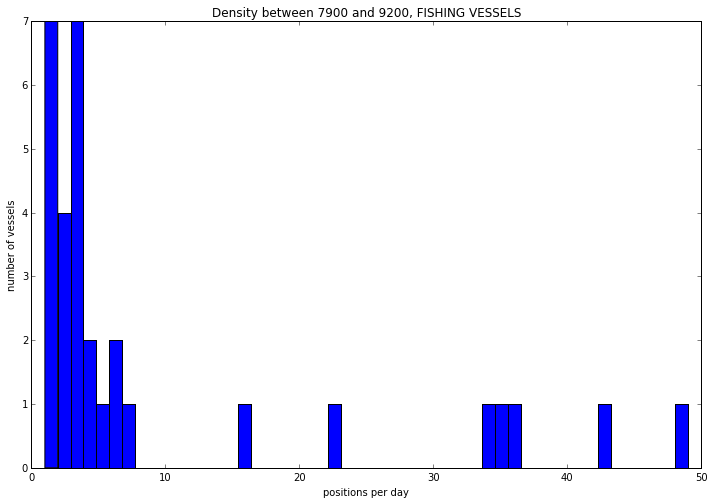

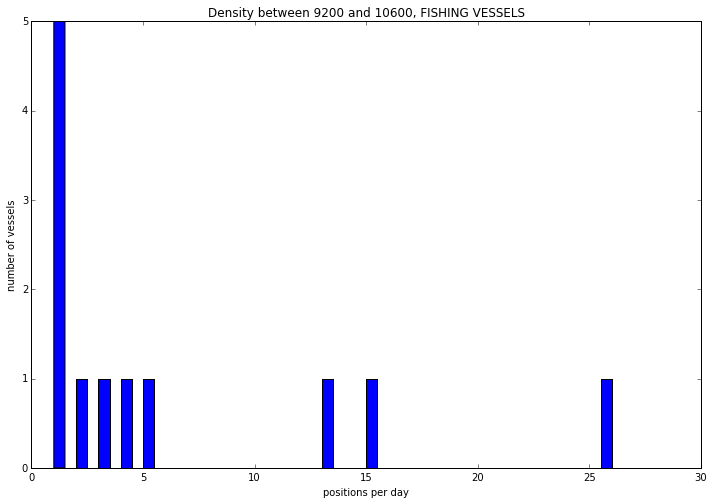

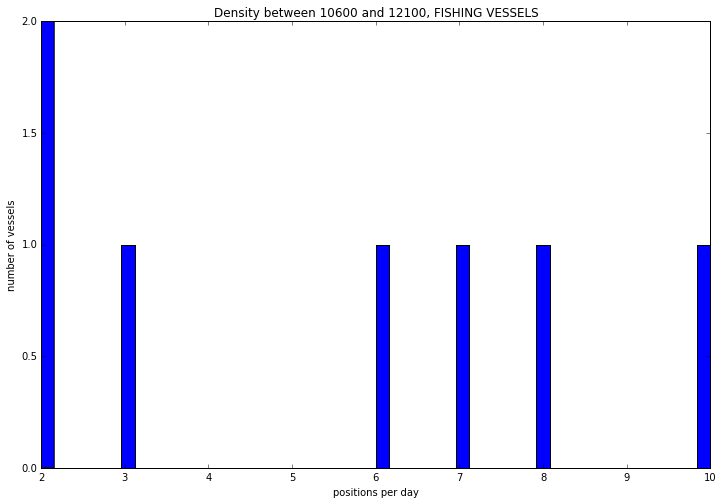

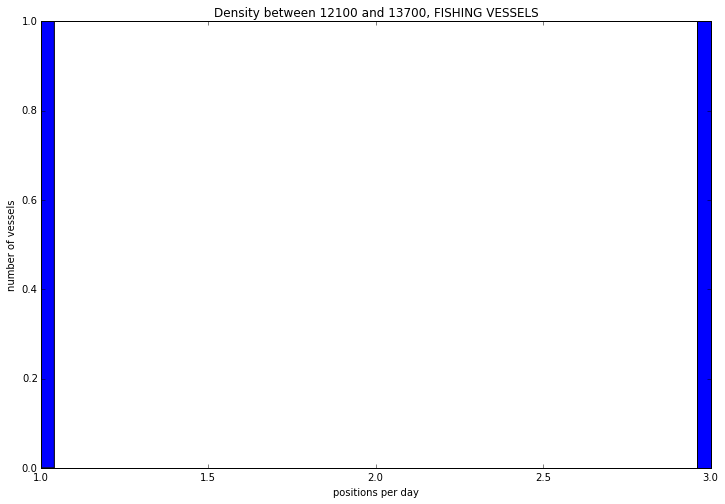

ValueError: x must have at least one data point

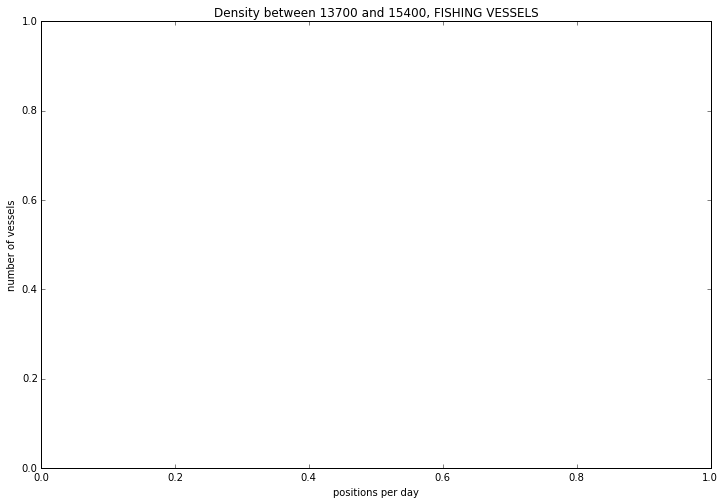

In [16]:
minimum = 0
maximum = 100

for i in range(18):

    x = []

    plt.clf()
    if i > 1:
        minimum = maximum
    maximum += 100*i

    for p, d in zip (pos, den):
        if d>minimum and d<maximum and p<400:
            x.append(p)
    plt.title("Density between "+str(minimum)+" and "+str(maximum)+", FISHING VESSELS")     
    plt.xlabel("positions per day")
    plt.ylabel("number of vessels")
    plt.hist(x, bins=50)
    plt.show()

In [ ]:
# okay, let's look at averages

q = '''
SELECT
  integer(FLOOR(a_avg_lat*10)) lat_bin_avg,
  integer(FLOOR(a_avg_lon*10)) lon_bin_avg,
  avg(a_satellite_positions) sat_positions,
  count(*)
  FROM
  [scratch_david_gapanalysis.ave_locations_2015_with_density_v2]
WHERE
  a_positions = a_satellite_positions
  and a_date = "2015-01-01"
  AND a_max_lat - a_min_lat <5
  AND (a_max_lon - a_min_lon < 10)
  AND a_mmsi IN (select mmsi from
[scratch_david_mmsi_lists.Combinedfishing_2014])
GROUP BY lat_bin_avg, lon_bin_avg
'''

positions_fishing_vessels_avgs = Query(q)


In [ ]:
# now make a chart of pings versus position

den = []
pos = []

for row in positions_fishing_vessels_avgs:
    lat = int(row[0])
    lon = int(row[1])
    sat_pos = row[2]
    number = int(row[3])
    # must only be satellite positions
    if lat<900 and lat>-900 and lon>-1800 and lon<1800:
        lat_index = (lat+900)/(cellsize*10)
        lon_index = (lon+1800)/(cellsize*10)
        den.append(averages[lat_index][lon_index])
        pos.append(float(sat_pos))

In [ ]:
x = den
y = pos

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
# ax.set_yscale('log')
# ax.set_xscale('log')

plt.scatter(np.log10(x), np.log10(y), alpha=.1)#, color = color)
# plt.scatter(x1, y1, alpha=1)#, color = color)

logA = np.log10(x)
logB = np.log10(y)
coefficients = np.polyfit(logA, logB, 1)
polynomial = np.poly1d(coefficients)
ys = polynomial(np.log10(x))
slope, intercept, r_value, p_value, std_err = stats.linregress(logA, logB)

plt.scatter(np.log10(x), ys, color = 'red')


# print slope
# print coefficients
# print r_value
# print p_value
print slope,std_err,p_value

plt.title("AVERAGE Satellite positions per day Versus Density FISHING VESSELS")
plt.xlabel('Log(vessels seen by satellite)')
plt.ylabel('Log(satellite positions)')

plt.show()

1318